In [194]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets, linear_model, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [195]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [196]:
trainData=train.copy()
testData=test.copy()

In [197]:
trainData.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [198]:
testData.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [199]:
trainData.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [200]:
# we have to replace all the spaces in the rows as when we want to convert the ordinal features in map it does not work with spaces
trainData.replace('\s+', '_',regex=True,inplace=True)
testData.replace('\s+', '_',regex=True,inplace=True)

In [201]:
obj_col = trainData.columns[trainData.dtypes == 'object'].values
#select non object columns
num_col = trainData.columns[trainData.dtypes != 'object'].values

print(obj_col)

['Item_Identifier' 'Item_Fat_Content' 'Item_Type' 'Outlet_Identifier'
 'Outlet_Size' 'Outlet_Location_Type' 'Outlet_Type']


In [202]:
#labels = data['Item_Fat_Content'].astype('category').cat.categories.tolist()
#itemFatMap = {'Item_Fat_Content' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
itemFatMap= {'LF': 1, 'Low_Fat': 1, 'Regular': 2, 'low_fat': 1, 'reg': 2}
labels = trainData['Item_Type'].astype('category').cat.categories.tolist()
itemTypeMap = {'Item_Type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = trainData['Outlet_Identifier'].astype('category').cat.categories.tolist()
outletIdentifierMap = {'Outlet_Identifier' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = trainData['Outlet_Size'].astype('category').cat.categories.tolist()
outletSizeMap = {'Outlet_Size' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = trainData['Outlet_Location_Type'].astype('category').cat.categories.tolist()
outletLocationMap = {'Outlet_Location_Type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = trainData['Outlet_Type'].astype('category').cat.categories.tolist()
outletTypeMap = {'Outlet_Type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}


In [203]:
print(itemFatMap)
print(itemTypeMap)
print(outletIdentifierMap)
print(outletSizeMap)
print(outletLocationMap)
print(outletTypeMap)

{'LF': 1, 'Low_Fat': 1, 'Regular': 2, 'low_fat': 1, 'reg': 2}
{'Item_Type': {'Baking_Goods': 1, 'Breads': 2, 'Breakfast': 3, 'Canned': 4, 'Dairy': 5, 'Frozen_Foods': 6, 'Fruits_and_Vegetables': 7, 'Hard_Drinks': 8, 'Health_and_Hygiene': 9, 'Household': 10, 'Meat': 11, 'Others': 12, 'Seafood': 13, 'Snack_Foods': 14, 'Soft_Drinks': 15, 'Starchy_Foods': 16}}
{'Outlet_Identifier': {'OUT010': 1, 'OUT013': 2, 'OUT017': 3, 'OUT018': 4, 'OUT019': 5, 'OUT027': 6, 'OUT035': 7, 'OUT045': 8, 'OUT046': 9, 'OUT049': 10}}
{'Outlet_Size': {'High': 1, 'Medium': 2, 'Small': 3}}
{'Outlet_Location_Type': {'Tier_1': 1, 'Tier_2': 2, 'Tier_3': 3}}
{'Outlet_Type': {'Grocery_Store': 1, 'Supermarket_Type1': 2, 'Supermarket_Type2': 3, 'Supermarket_Type3': 4}}


In [204]:

trainData["Item_Fat_Content"] = trainData["Item_Fat_Content"].map(itemFatMap)
trainData.replace(itemTypeMap, inplace=True)
trainData.replace(outletIdentifierMap, inplace=True)
trainData.replace(outletSizeMap, inplace=True)
trainData.replace(outletLocationMap, inplace=True)
trainData.replace(outletTypeMap, inplace=True)

In [205]:
testData["Item_Fat_Content"] = testData["Item_Fat_Content"].map(itemFatMap)
testData.replace(itemTypeMap, inplace=True)
testData.replace(outletIdentifierMap, inplace=True)
testData.replace(outletSizeMap, inplace=True)
testData.replace(outletLocationMap, inplace=True)
testData.replace(outletTypeMap, inplace=True)

In [206]:
trainData.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,1,0.016047,5,249.8092,10,1999,2.0,1,2,3735.1380
1,DRC01,5.92,2,0.019278,15,48.2692,4,2009,2.0,3,3,443.4228
2,FDN15,17.50,1,0.016760,11,141.6180,10,1999,2.0,1,2,2097.2700
3,FDX07,19.20,2,0.000000,7,182.0950,1,1998,NaN,3,1,732.3800
4,NCD19,8.93,1,0.000000,10,53.8614,2,1987,1.0,3,2,994.7052


Checking null values 

In [207]:
trainData.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

(array([483., 870., 865., 664., 779., 629., 755., 735., 677., 603.]),
 array([ 4.555 ,  6.2345,  7.914 ,  9.5935, 11.273 , 12.9525, 14.632 ,
        16.3115, 17.991 , 19.6705, 21.35  ]),
 <a list of 10 Patch objects>)

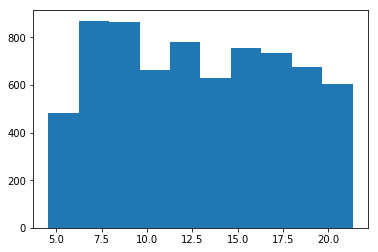

In [208]:
plt.hist(trainData.Item_Weight)

(array([ 932.,    0.,    0.,    0.,    0., 2793.,    0.,    0.,    0.,
        2388.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

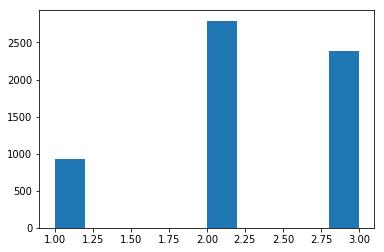

In [209]:
plt.hist(trainData.Outlet_Size)

In [210]:
X=trainData[trainData['Outlet_Size'].isnull() | trainData['Item_Weight'].isnull()]

In [211]:
# replacing nan values with mode and median

In [212]:
trainData.drop(['Item_Identifier'], axis=1, inplace=True)


In [213]:
dataCopy=trainData.copy(deep=True)

In [214]:
trainData['Item_Weight'] = trainData['Item_Weight'].fillna((trainData['Item_Weight'].mode()))
trainData['Outlet_Size'] = trainData['Outlet_Size'].fillna((trainData['Outlet_Size'].mode()[0]))


testData['Item_Weight'] = testData['Item_Weight'].fillna((testData['Item_Weight'].mode()))
testData['Outlet_Size'] = testData['Outlet_Size'].fillna((testData['Outlet_Size'].mode()[0]))


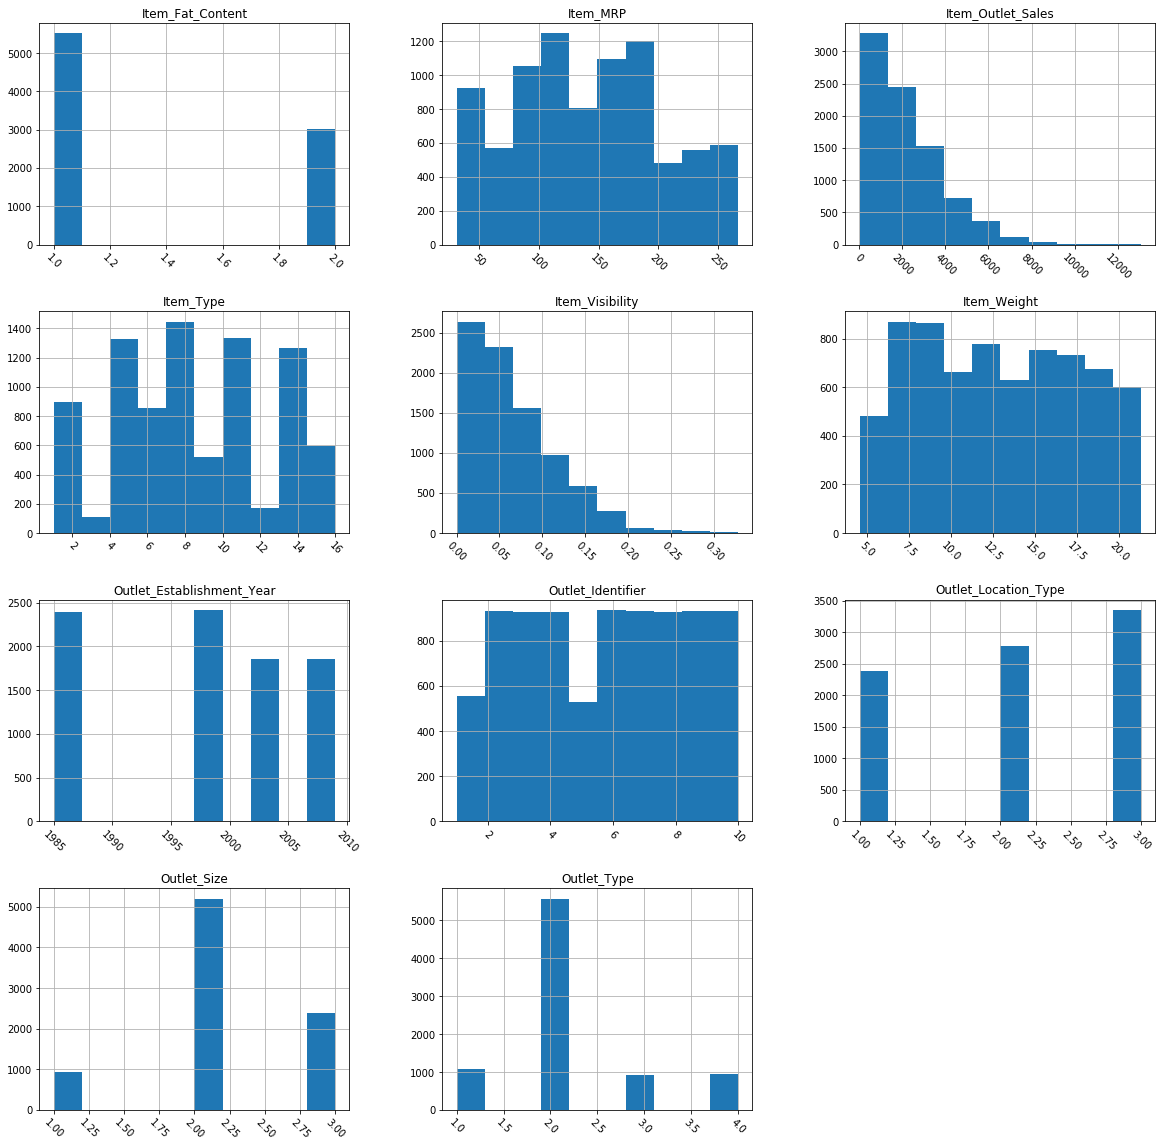

In [215]:
# Plot histogram grid
trainData.hist(figsize=(20,20), xrot=-45)

# Clear the text "residue"
plt.show()

In [216]:
trainData['Shop_Age']=2013-trainData['Outlet_Establishment_Year']
testData['Shop_Age']=2013-testData['Outlet_Establishment_Year']

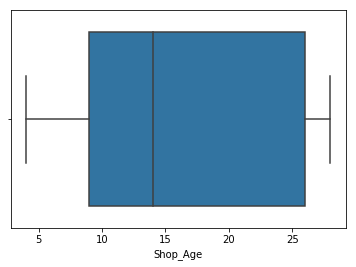

In [217]:
sns.boxplot(trainData['Shop_Age'])

Lets see if the age affects the sale

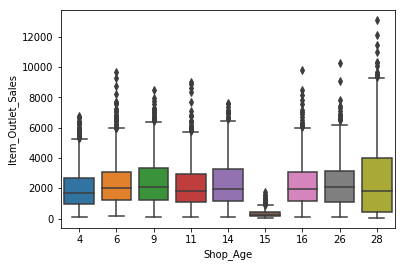

In [218]:
sns.boxplot(x="Shop_Age", y="Item_Outlet_Sales", data=trainData)

Here we can observe a special trend of old_shops having large number of outliers in sales while shop aged =15 are having a drop in sales 

In [219]:
trainData.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales', 'Shop_Age'],
      dtype='object')

In [220]:
selected_features=['Item_MRP','Outlet_Type','Outlet_Location_Type','Shop_Age']

In [221]:
X1=trainData[selected_features]

In [222]:
Y1=trainData['Item_Outlet_Sales']

In [223]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit on the training data
scaler.fit(X1)
# Transform both the training and testing data
X1_scaled = scaler.transform(X1)

In [224]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [225]:
models = []
models.append(('LR', LinearRegression()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('LGBM', LGBMRegressor()))
models.append(('RF', RandomForestRegressor()))

In [226]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1_scaled,Y1, test_size=0.33, random_state=33)

In [227]:
def cal_rmse(predicted,actual):
    return math.sqrt((sum((predicted-actual)**2))/len(predicted))

In [228]:
rmse=[]
names=[]
import math 
for name, model in models:
    model.fit(X_train1,y_train1)
    y_pred1=model.predict(X_test1)
    names.append(name)
    rmse=cal_rmse(y_pred1,y_test1)
    print(name,rmse)

LR 1215.9479449336575
CART 1575.4830802060721
XGB 1083.6596183338872
LGBM 1108.0204468807992
RF 1288.361249882873


In [229]:
model1=XGBRegressor()

In [230]:
model1.fit(X1_scaled,Y1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [231]:
cols=X1.columns
test1=testData[cols]
scaler.fit(test1)
test1_scaled=scaler.transform(test1)


In [232]:
pred1=model1.predict(test1_scaled)

In [233]:
ids=testData['Item_Identifier']
outlet=test['Outlet_Identifier']
submission = pd.DataFrame({'Item_Identifier': ids,
                           'Outlet_Identifier':outlet,
                           'Item_Outlet_Sales':pred1
                           })

submission.to_csv("selectedFeaturesXGB.csv")

# Hyperparameter tuning

In [234]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

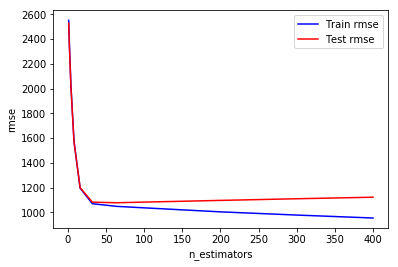

In [235]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200,300,400]
train_results = []
test_results = []
for estimator in n_estimators:
   xgb = XGBRegressor(n_estimators=estimator, n_jobs=1)
   xgb.fit(X_train1, y_train1)
   train_pred = xgb.predict(X_train1)
   rmse_train=cal_rmse(train_pred,y_train1)
   train_results.append(rmse_train)
   y_pred = xgb.predict(X_test1)
   rmse_test=cal_rmse(y_pred,y_test1)
   test_results.append(rmse_test)
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(n_estimators, train_results, color="blue", label='Train rmse')
line2 = plt.plot(n_estimators, test_results, color="red", label='Test rmse')
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('rmse')
plt.xlabel('n_estimators')
plt.legend(loc='upper right')
plt.show()

We can observe that the n_estimator after 30 is not affecting the rmse of the test set 

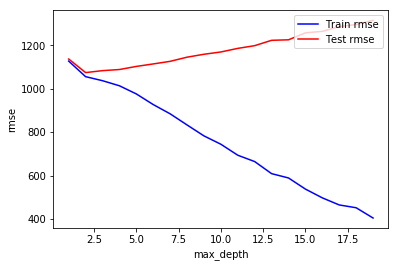

In [236]:
max_depth = [i for i in range(1,20)]
train_results = []
test_results = []
for estimator in max_depth:
   xgb = XGBRegressor(max_depth=estimator, n_jobs=1)
   xgb.fit(X_train1, y_train1)
   train_pred = xgb.predict(X_train1)
   rmse_train=cal_rmse(train_pred,y_train1)
   train_results.append(rmse_train)
   y_pred = xgb.predict(X_test1)
   rmse_test=cal_rmse(y_pred,y_test1)
   test_results.append(rmse_test)
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(max_depth, train_results, color="blue", label='Train rmse')
line2 = plt.plot(max_depth, test_results, color="red", label='Test rmse')
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('rmse')
plt.xlabel('max_depth')
plt.legend(loc='upper right')
plt.show()

We can observe the tresnd where the rmse for test set is increasing after max_depth=2.5 , thus we can choose max_depth =2

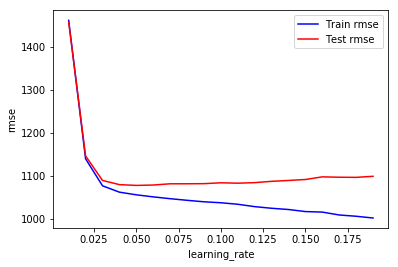

In [237]:
learning_rate=[i for i in np.arange(0.01,0.2,0.01)]
train_results = []
test_results = []
for estimator in learning_rate:
   xgb = XGBRegressor(learning_rate=estimator, n_jobs=1)
   xgb.fit(X_train1, y_train1)
   train_pred = xgb.predict(X_train1)
   rmse_train=cal_rmse(train_pred,y_train1)
   train_results.append(rmse_train)
   y_pred = xgb.predict(X_test1)
   rmse_test=cal_rmse(y_pred,y_test1)
   test_results.append(rmse_test)
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(learning_rate, train_results, color="blue", label='Train rmse')
line2 = plt.plot(learning_rate, test_results, color="red", label='Test rmse')
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('rmse')
plt.xlabel('learning_rate')
plt.legend(loc='upper right')
plt.show()

we can choose the learning rate of 0.05 as after that the rmse is increasing slowly for test set

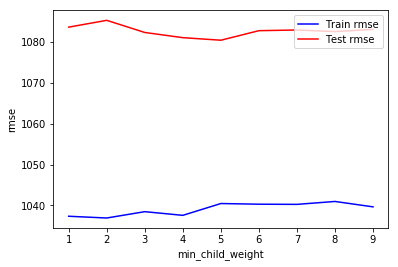

In [238]:
#min_child_weight
min_child_weight=[i for i in np.arange(1,10)]
train_results = []
test_results = []
for estimator in min_child_weight:
   xgb = XGBRegressor(min_child_weight=estimator, n_jobs=1)
   xgb.fit(X_train1, y_train1)
   train_pred = xgb.predict(X_train1)
   rmse_train=cal_rmse(train_pred,y_train1)
   train_results.append(rmse_train)
   y_pred = xgb.predict(X_test1)
   rmse_test=cal_rmse(y_pred,y_test1)
   test_results.append(rmse_test)
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(min_child_weight, train_results, color="blue", label='Train rmse')
line2 = plt.plot(min_child_weight, test_results, color="red", label='Test rmse')
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('rmse')
plt.xlabel('min_child_weight')
plt.legend(loc='upper right')
plt.show()

Thus we can see that the min_child_weight can be taken as 5 for min rmse for test set

Choosing parameters
min_child_weight=5,
learning_rate=0.05,
max_depth=2,
n_estimator=30



In [239]:
model_tuned=XGBRegressor(min_child_weight=5, learning_rate=0.05, max_depth=2, n_estimator=30)

In [240]:
model_tuned.fit(X_train1,y_train1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=5, missing=None, n_estimator=30,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [241]:
pred_tuned=model_tuned.predict(X_test1)

In [242]:
cal_rmse(pred_tuned,y_test1)

1081.420267932125

We can observe the change in rmse from simple model to tuned model

In [243]:
pred_tuned_test=model_tuned.predict(test1_scaled)
ids=testData['Item_Identifier']
outlet=test['Outlet_Identifier']
submission = pd.DataFrame({'Item_Identifier': ids,
                           'Outlet_Identifier':outlet,
                           'Item_Outlet_Sales':pred1
                           })

submission.to_csv("selectedFeaturesXGB_tuned.csv")